In [1]:
import os
import sys
import tqdm
import torch
import botorch
import gpytorch
import pygmo as pg

import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

# plt.rcParams['text.usetex'] = True
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [2]:
import aegis

In [3]:
def plot_1d_model(
    model, likelihood, xrange=[0, 1], ax=None, dtype=torch.double
):
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    #     print(
    #         f"Lengthscale: {model.covar_module.base_kernel.lengthscale.item():0.5f}",
    #         f"Variance: {model.covar_module.outputscale.item():0.5f}",
    #     )

    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad():
        test_x = torch.linspace(
            xrange[0], xrange[1], 1000, dtype=dtype
        ).unsqueeze(-1)

        observed_pred = likelihood(
            model(test_x),
            noise=model.likelihood.noise.mean().expand(test_x.shape[0]),
        )

        # get the training points, mean and +/- 2sigma region
        (train_x, *_) = model.train_inputs
        train_y = model.train_targets
        mu = observed_pred.mean
        lower, upper = observed_pred.confidence_region()

        # convert it all to flattened numpy arrays for matplotlib
        test_x = test_x.numpy().ravel()
        train_x = train_x.numpy().ravel()
        train_y = train_y.numpy()
        mu = mu.numpy()
        lower = lower.numpy()
        upper = upper.numpy()

    oldax = ax
    if oldax is None:
        fig, ax = plt.subplots(1, 1, figsize=(7, 4))

    # training data
    ax.plot(
        train_x,
        train_y,
        "o",
        color="k",
        alpha=1,
        label="Observations",
        zorder=15,
        ms=6,
    )
    
    # confidence bounds
    ax.fill_between(
        test_x,
        lower,
        upper,
        color="g",
        alpha=0.2,
        label="$\pm 2 \sigma(\mathbf{x})$",
        zorder=1,
    )

    # predicted mean
    ax.plot(test_x, mu, "g-", label=r"$\mu(\mathbf{x})$", lw=2)

    ax.set_xlim(xrange)

    #     handles, labels = ax.get_legend_handles_labels()
    #     order = [0,2,1]
    #     ax.legend([handles[idx] for idx in order],
    #               [labels[idx] for idx in order],
    #               loc='upper center',
    #               fontsize=10, ncol=3)

    if oldax is None:
        plt.show()

    return [lower.min(), upper.max()]

# Initial BO plots with GP and EI

In [4]:
dtype = torch.float

problem_name = "Forrester"
transform_name = "Transform_Standardize"
acq_func_name = "EI"

ls_bounds = [0.1, 1]
out_bounds = [1e-4, 10]

ls_prior = gpytorch.priors.UniformPrior(*ls_bounds)
os_prior = gpytorch.priors.UniformPrior(*out_bounds)

# load the problem instance
f = getattr(aegis.test_problems, problem_name)()

# wrap the problem for torch and so that it resides in [0, 1]^d
f = aegis.util.TorchProblem(aegis.util.UniformProblem(f))
problem_bounds = torch.stack((f.lb, f.ub)).float()

transform_function = getattr(aegis.transforms, transform_name)

ls_prior = gpytorch.priors.GammaPrior(3, 6)
os_prior = gpytorch.priors.GammaPrior(2.0, 0.15)

In [5]:
seed = 42
rng = np.random.default_rng(seed)

Xtr = torch.tensor([0.05, 0.25, 0.65, 0.9], dtype=dtype).reshape(-1, 1)
Ytr = f(Xtr).squeeze()

Xte = torch.linspace(0, 1, 10000).reshape(-1, 1)
Yte = f(Xte).squeeze()

T_out = transform_function(Yte)

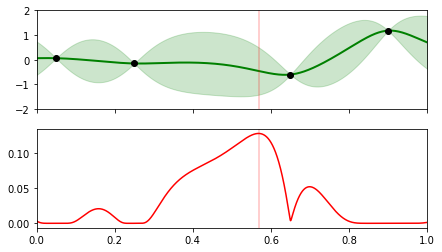

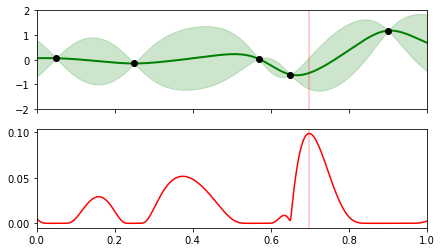

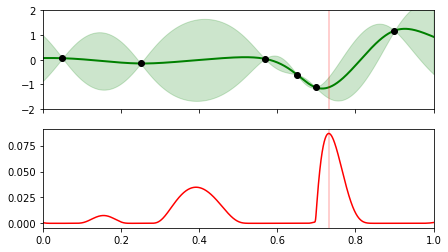

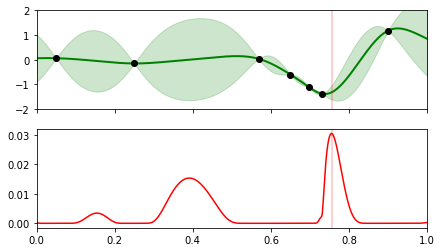

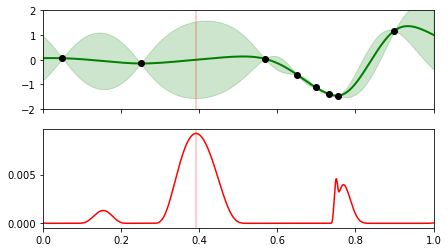

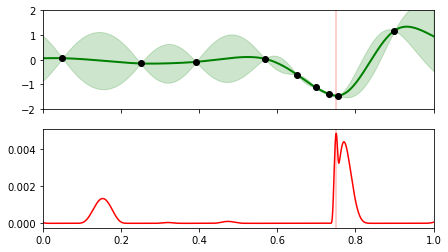

In [6]:
Xtrs = []
Ytrs = []
models = []
acqs = []
EIs = []

for _ in range(6):
    train_y = T_out.scale_mean(Ytr)
    train_x = Xtr

    model, likelihood = aegis.gp.create_and_fit_GP(
        train_x,
        train_y,
        ls_bounds,
        out_bounds,
        10,
        verbose=False,
        noise_size=1e-4,
    )

    EI = botorch.acquisition.ExpectedImprovement(
        model, best_f=train_y.min().reshape(1), maximize=False
    )

    train_xnew, acq_f = botorch.optim.optimize_acqf(
        acq_function=EI,
        bounds=problem_bounds.float(),
        q=1,
        num_restarts=10,
        raw_samples=10000,
    )

    fig, (ax, eiax) = plt.subplots(2, 1, figsize=(7, 4), sharex=True)
    # ax.plot(test_x, test_y, 'k--', alpha=0.25)
    plot_1d_model(model, likelihood, ax=ax, dtype=dtype)
    ax.set_ylim([-2, 2])
    ax.axvline(train_xnew.item(), c="r", alpha=0.25)

    with torch.no_grad():
        ei = EI(Xte.reshape(-1, 1, 1)).detach().numpy().ravel()
        
    eiax.plot(
        Xte.numpy().ravel(), ei, "r",
    )

    eiax.axvline(train_xnew.item(), c="r", alpha=0.25)

    plt.show()

    # store everything
    Xtrs.append(train_x)
    Ytrs.append(train_y)
    models.append(model)
    acqs.append(EI)
    EIs.append(ei)

    train_ynew = f(train_xnew)

    Xtr = torch.cat((Xtr, train_xnew))
    Ytr = torch.cat((Ytr, train_ynew))

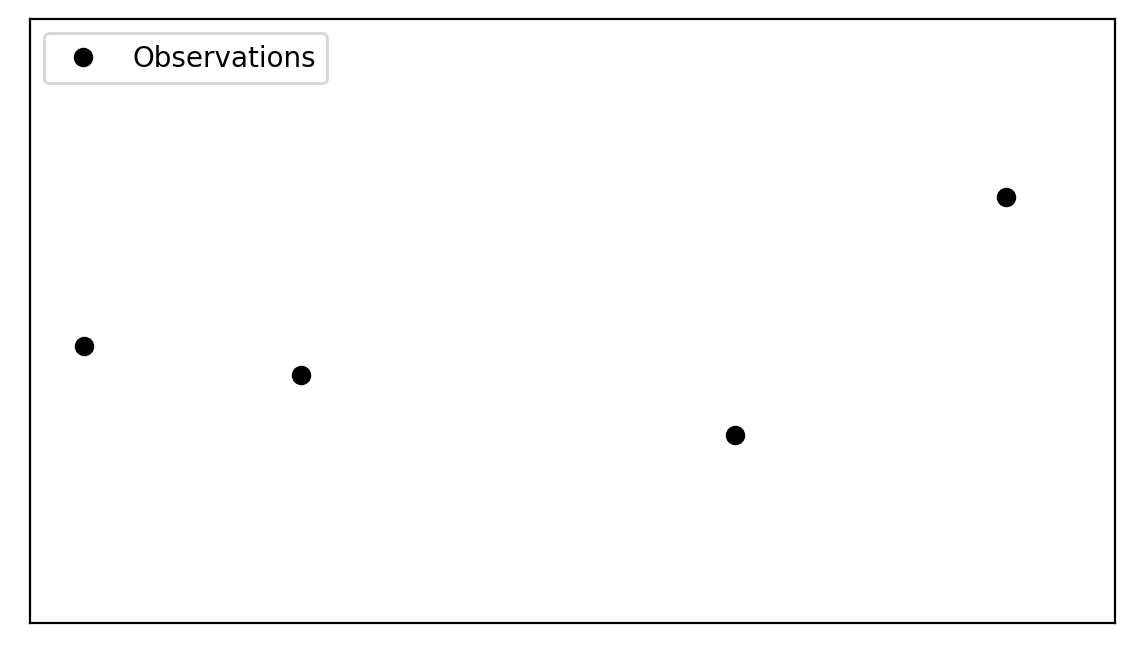

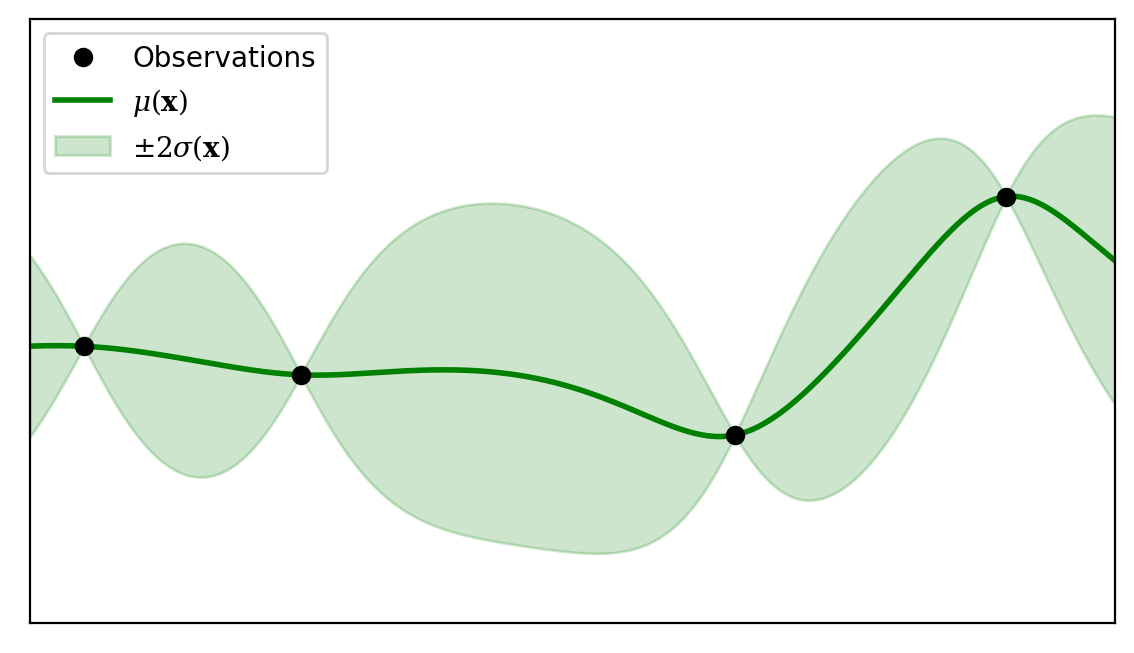

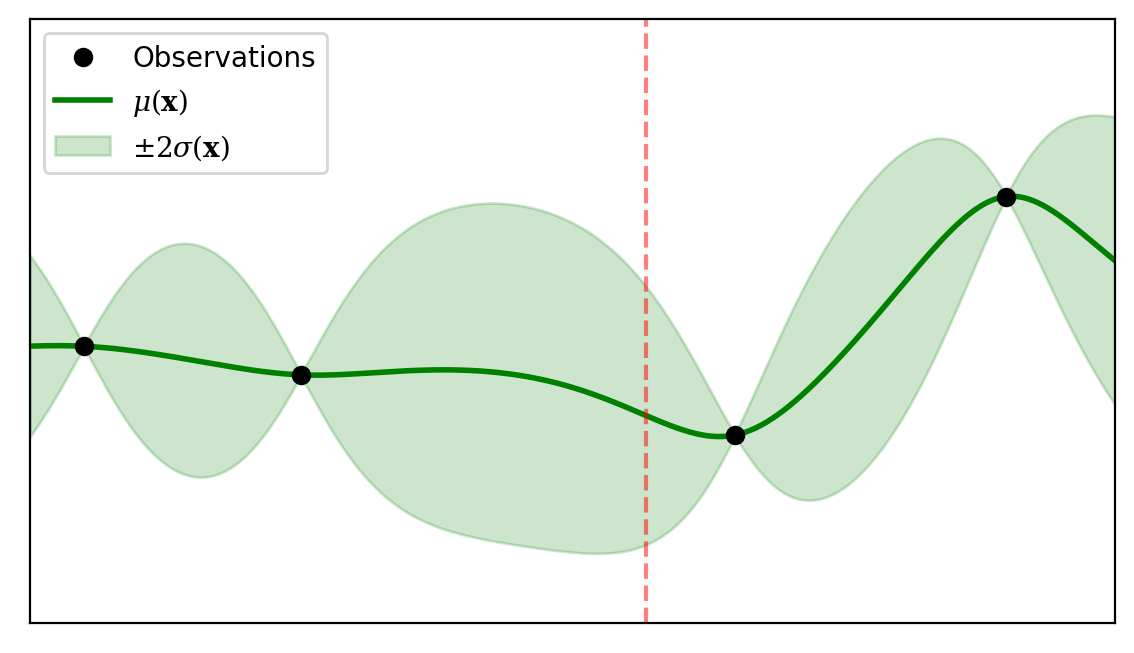

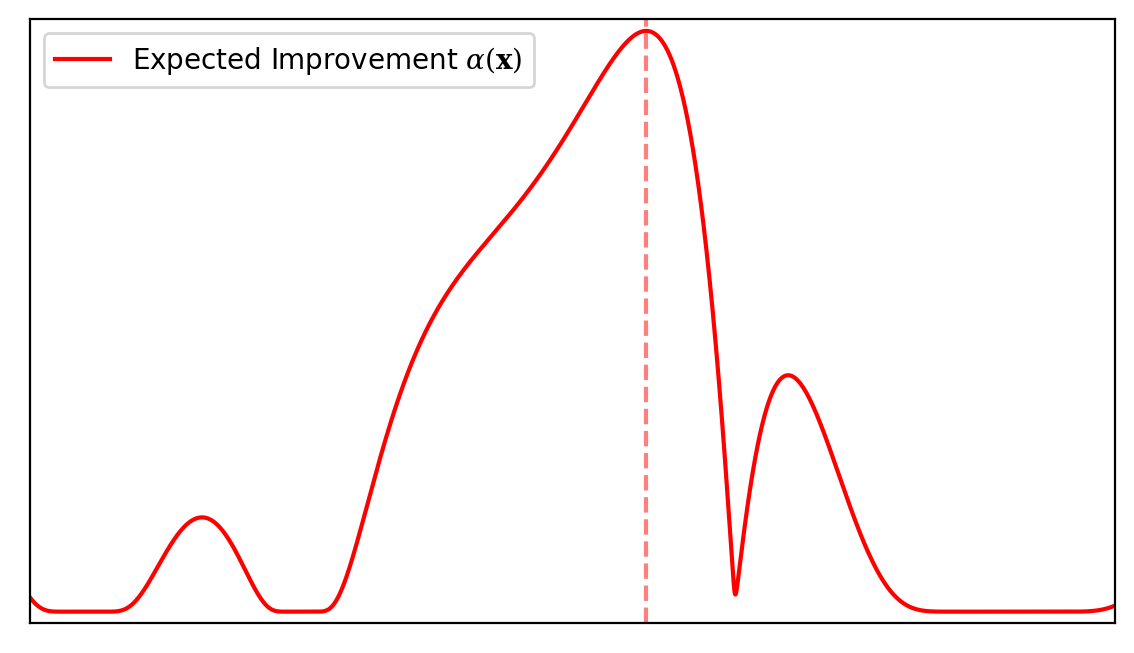

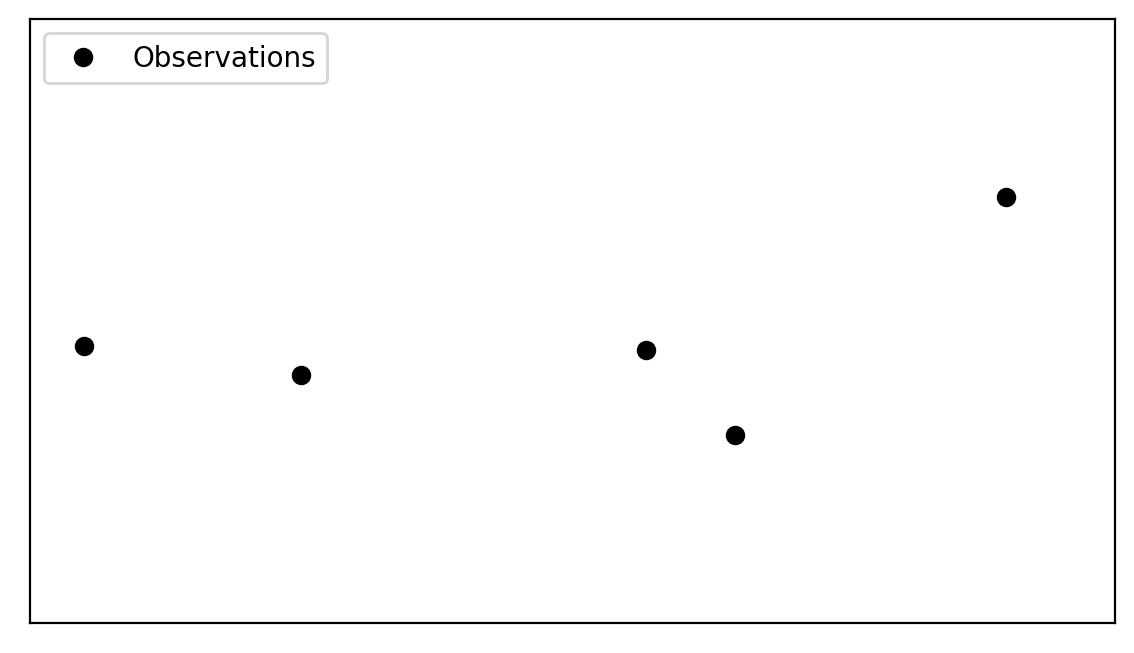

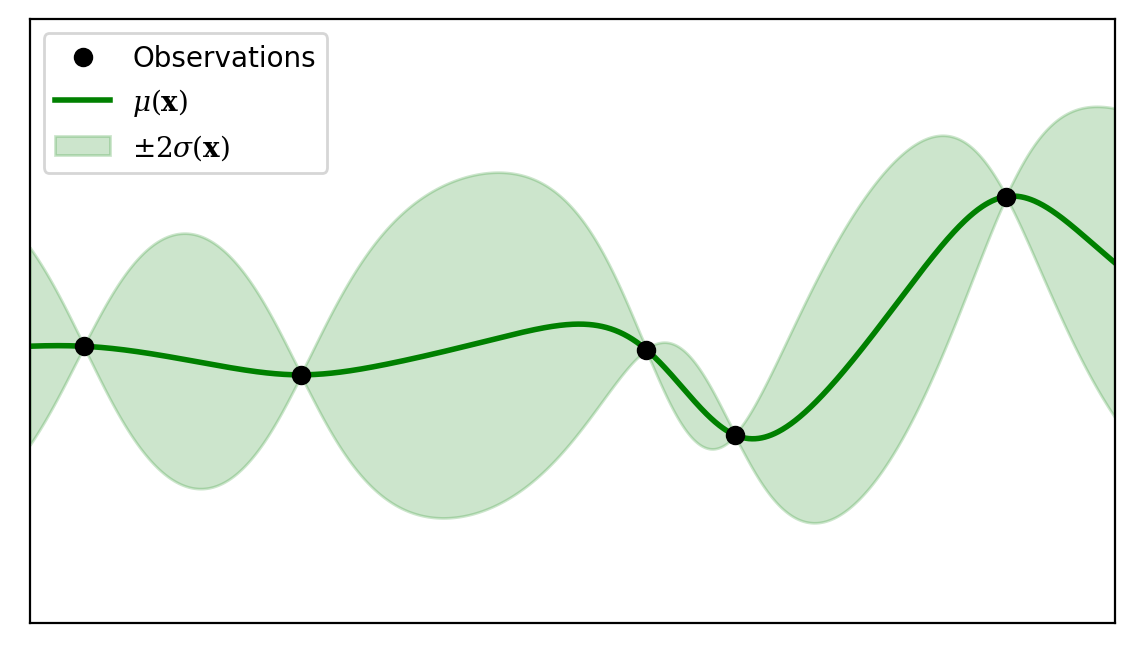

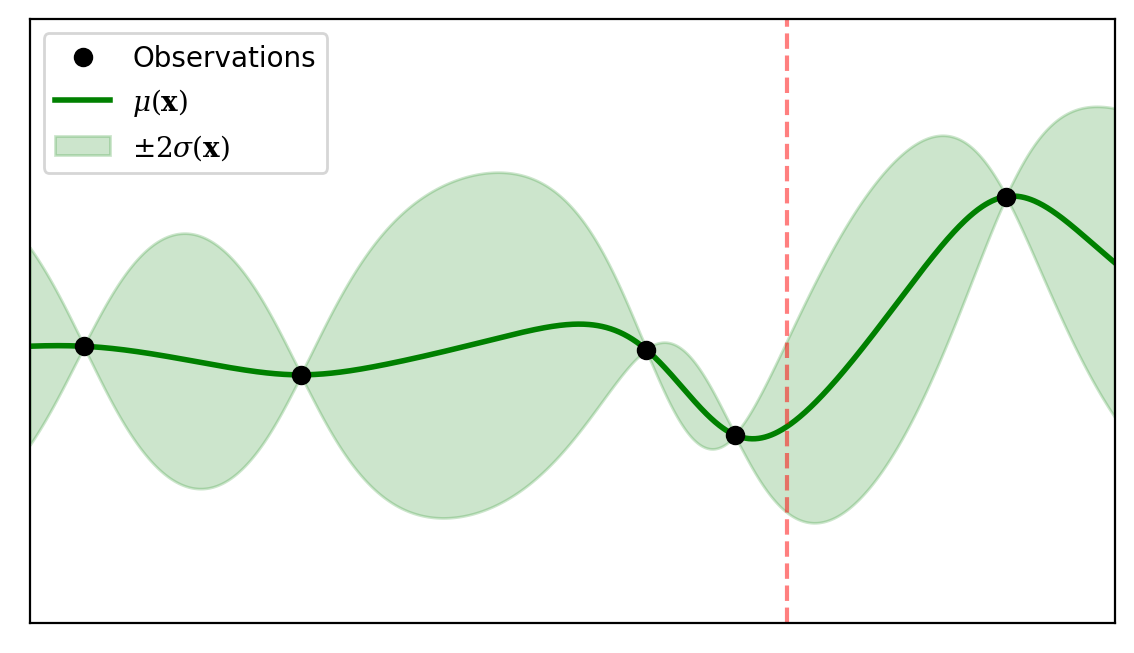

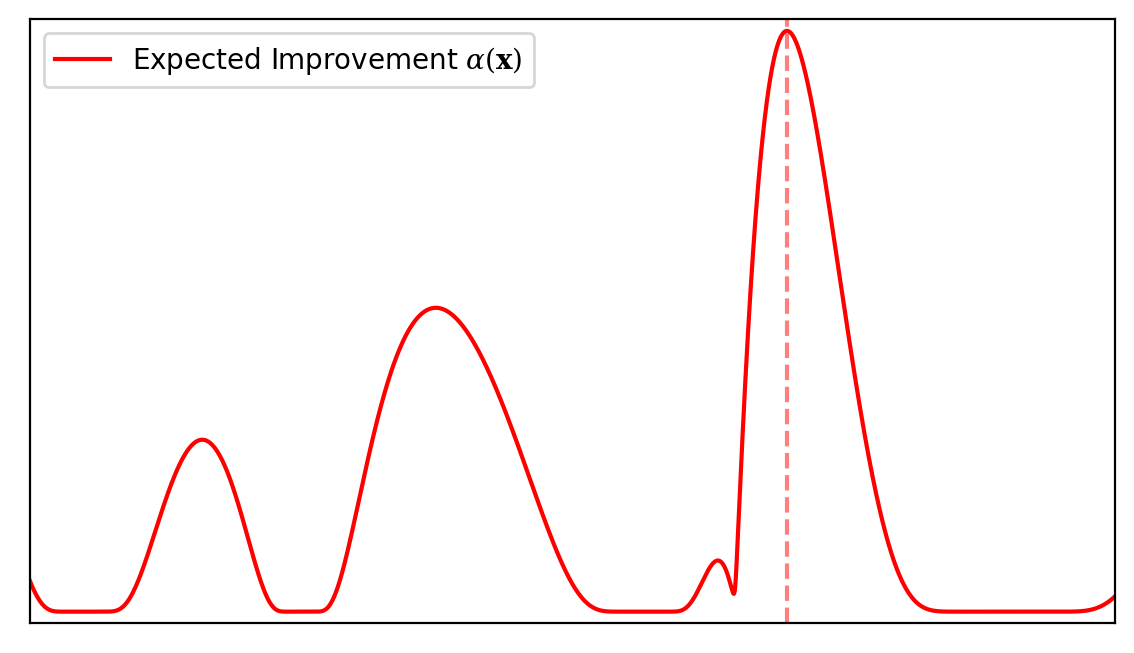

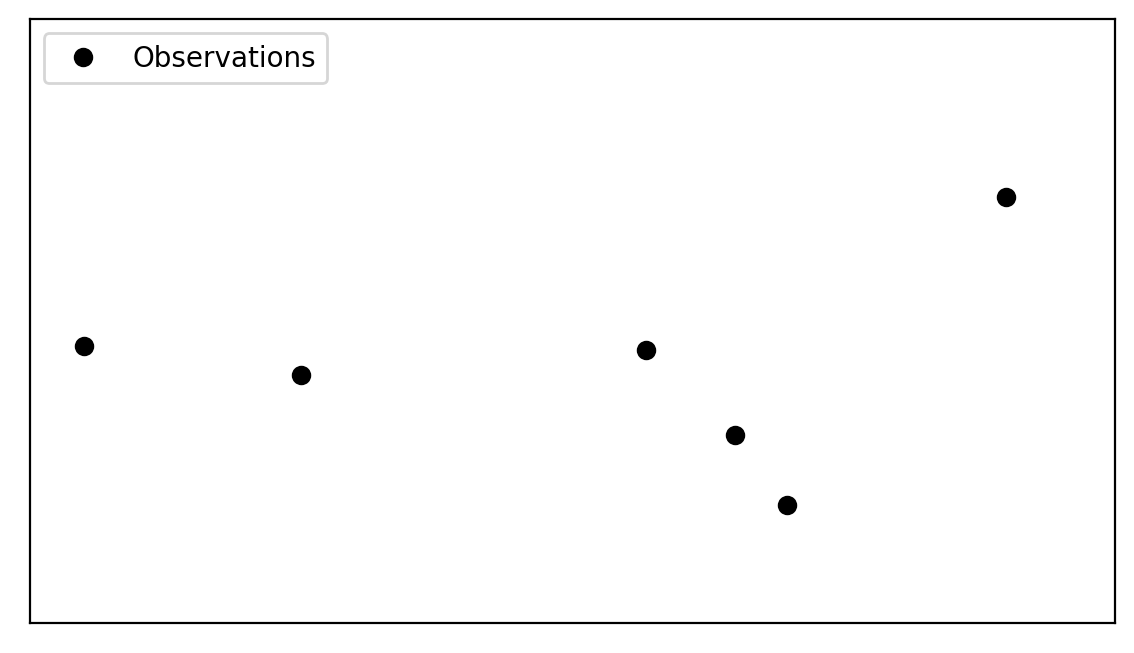

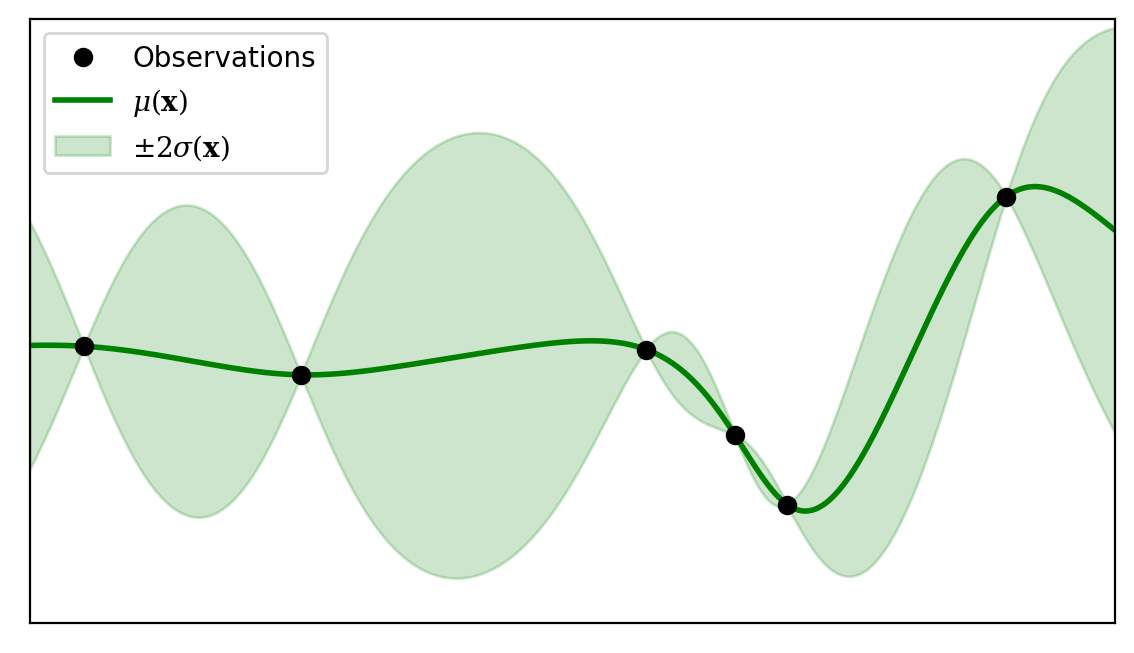

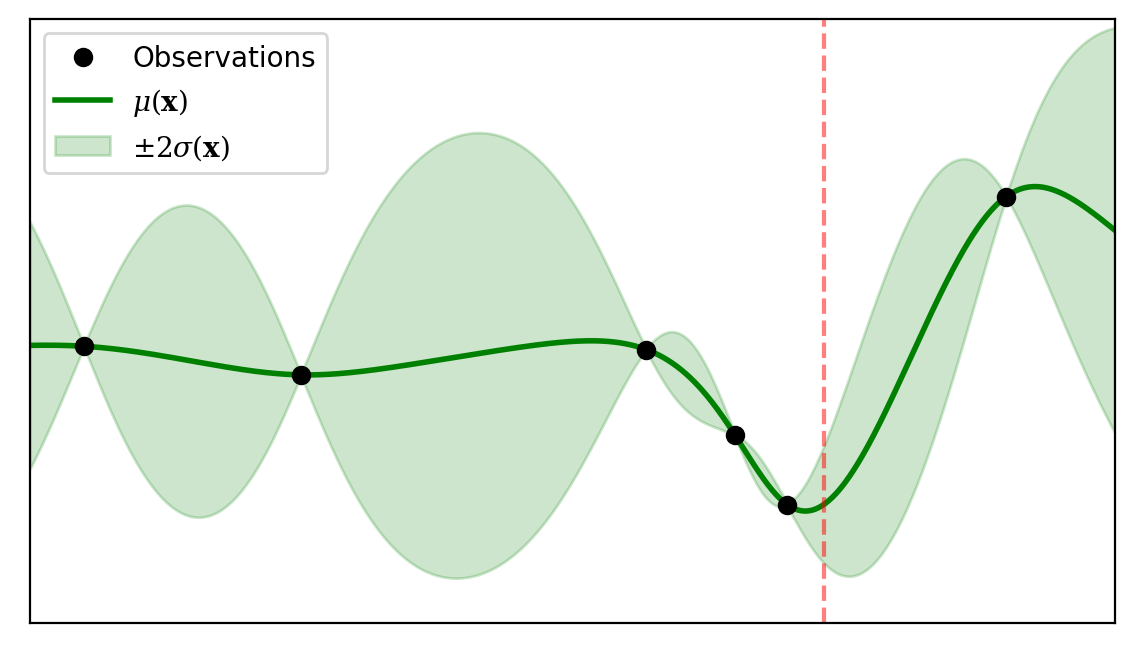

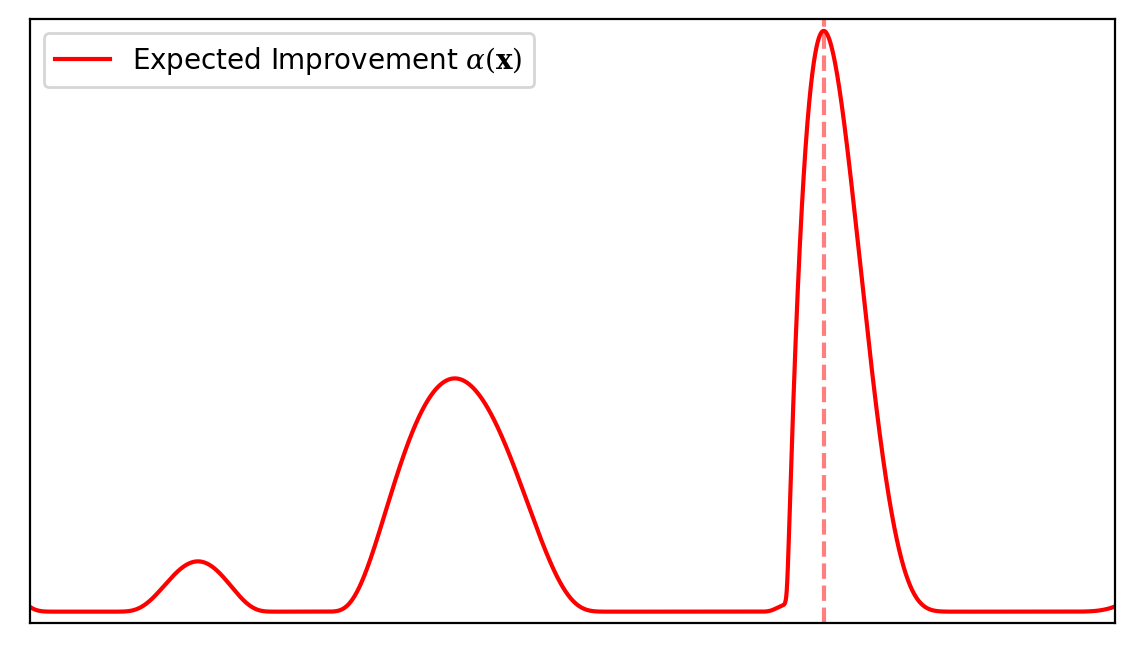

In [7]:
def get_1_axis(xlim, ylim, figsize=(7, 4)):
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=200)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks([])
    ax.set_yticks([])
    return ax


# settings for plots
xlim = [0, 1]  # GP and EI
gp_ylim = [-2, 2.5]  # GP range
ei_ylim = [-0.02, 1.02]  # EI range (assume EI rescaled to [0, 1])

for t in [0, 1, 2]:
    X = Xtrs[t]
    y = Ytrs[t]
    model = models[t]
    ei = EIs[t]
    ei /= ei.max()
    ei_x = Xte.ravel()[np.argmax(ei)]

    # training data
    ax = get_1_axis(xlim, gp_ylim)
    ax.plot(
        X, y, "o", color="k", alpha=1, label="Observations", zorder=15, ms=6,
    )
    ax.legend(loc="upper left", ncol=1)
    plt.savefig(f"BO_{3*t}_data.pdf", bbox_inches="tight")
    plt.show()

    # fitted model
    ax = get_1_axis(xlim, gp_ylim)
    plot_1d_model(model, likelihood, xrange=[0, 1], ax=ax, dtype=dtype)
    ax.legend(loc="upper left")
    plt.savefig(f"BO_{3*t + 1}_GP.pdf", bbox_inches="tight")
    plt.show()

    # maximised EI, shown on EI and model
    ax = get_1_axis(xlim, gp_ylim)
    plot_1d_model(model, likelihood, xrange=[0, 1], ax=ax, dtype=dtype)
    ax.axvline(ei_x, color="r", ls="--", alpha=0.5)
    ax.legend(loc="upper left", ncol=1)
    plt.savefig(f"BO_{3*t + 2}_GP.pdf", bbox_inches="tight")
    plt.show()

    ax = get_1_axis(xlim, ei_ylim)#, figsize=(7, 3))
    ax.plot(Xte, ei, c="r", label=r"Expected Improvement $\alpha(\mathbf{x})$")
    ax.axvline(ei_x, color="r", ls="--", alpha=0.5)
    ax.legend(loc="upper left", ncol=3)
    plt.savefig(f"BO_{3*t + 2}_EI.pdf", bbox_inches="tight")
    plt.show()

## Thompson Sampling plots

In [8]:
t = 1
model = models[t]
likelihood = model.likelihood

with torch.no_grad():
    output = likelihood(
        model(Xte), noise=likelihood.noise.mean().expand(Xte.shape[0]),
    )
    torch.manual_seed(0)
    g = output.rsample()
    
torch.manual_seed(18)
g = output.rsample()
xmin = Xte.ravel()[np.argmin(g.numpy())]

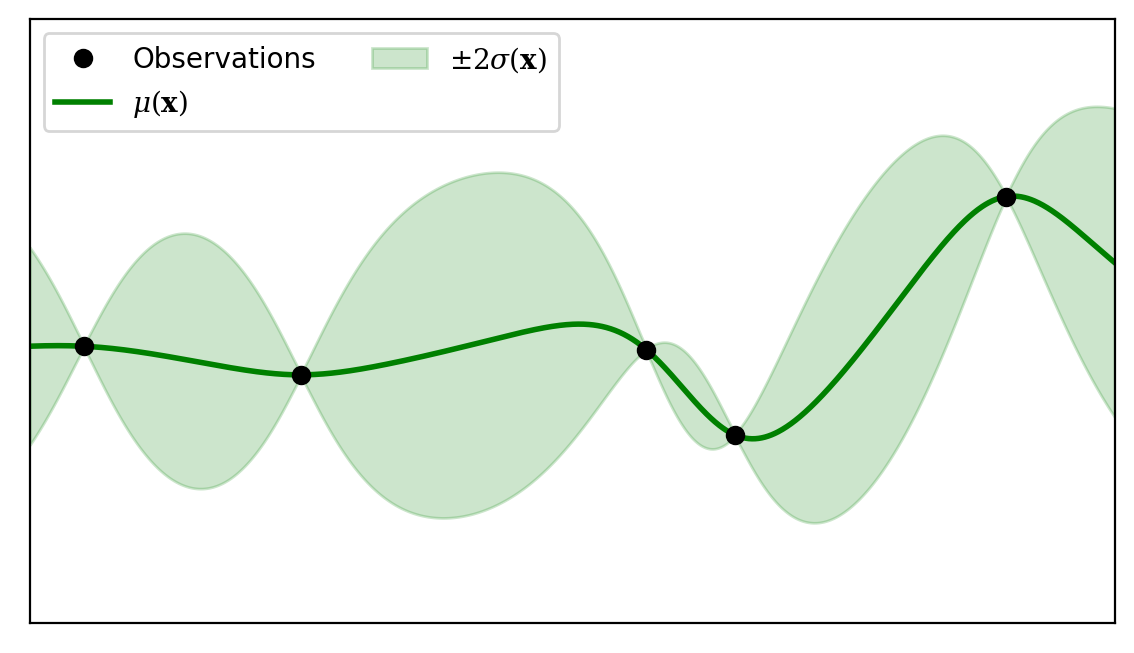

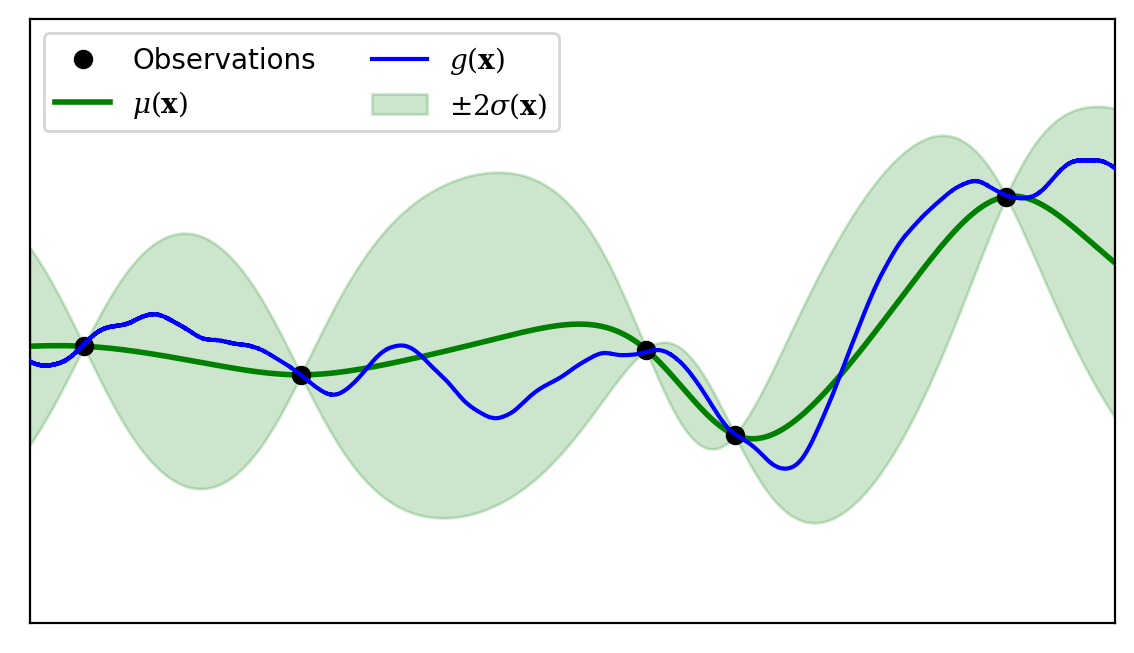

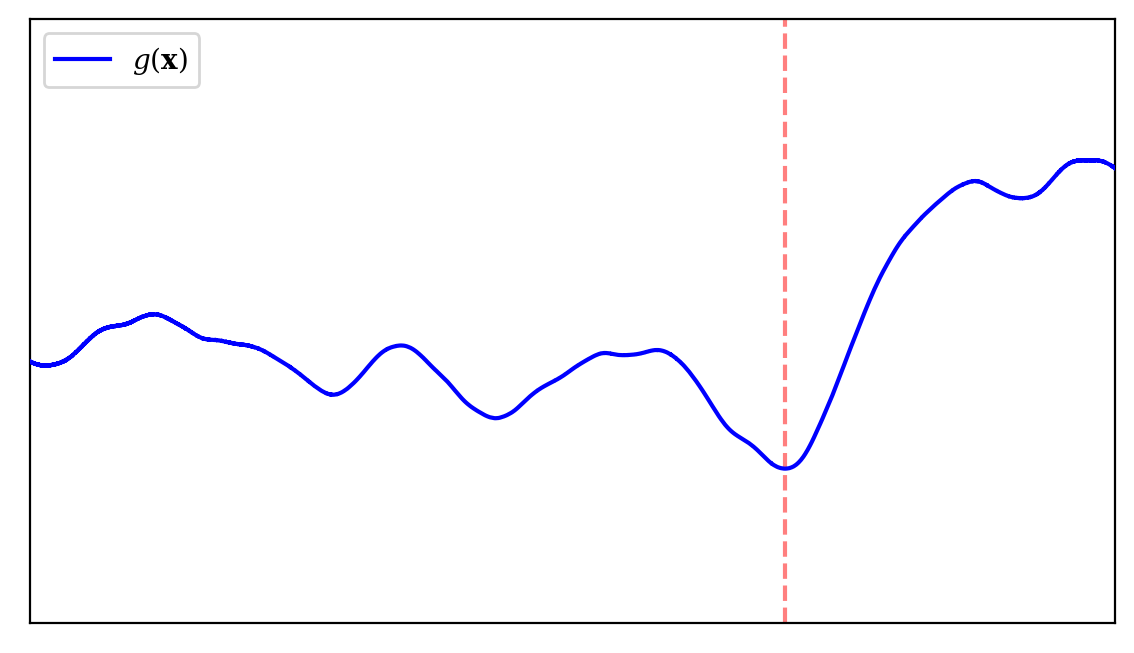

In [9]:
ax = get_1_axis(xlim, gp_ylim)
plot_1d_model(model, likelihood, xrange=[0, 1], ax=ax, dtype=dtype)
ax.legend(loc="upper left", ncol=2)
plt.savefig(f"TS_0_GP.pdf", bbox_inches="tight")
plt.show()

ax = get_1_axis(xlim, gp_ylim)
plot_1d_model(model, likelihood, xrange=[0, 1], ax=ax, dtype=dtype)
ax.plot(Xte.ravel(), g, "b-", zorder=999, label=r"$g(\mathbf{x})$")
ax.legend(loc="upper left", ncol=2)
plt.savefig(f"TS_1_GP_and_TS.pdf", bbox_inches="tight")
plt.show()

ax = get_1_axis(xlim, gp_ylim)
ax.plot(Xte.ravel(), g, "b-", zorder=999, label=r"$g(\mathbf{x})$")
ax.axvline(xmin, color="r", ls="--", alpha=0.5)
ax.legend(loc="upper left", ncol=2)
plt.savefig(f"TS_2_TSmin.pdf", bbox_inches="tight")
plt.show()

### $\epsilon$-greedy with Pareto set selection.

In [10]:
t = 1
model = models[t]
likelihood = model.likelihood

xtest = Xte[::10, :]

with torch.no_grad():
    output = likelihood(
        model(xtest), noise=likelihood.noise.mean().expand(xtest.shape[0]),
    )
    mu = output.mean.numpy()
    sigma = output.stddev.numpy()

musigma = np.stack([mu, -sigma]).T  # n by 2

front_inds = pg.non_dominated_front_2d(musigma)
front_mask = np.array([x in front_inds for x in np.arange(musigma.shape[0])])

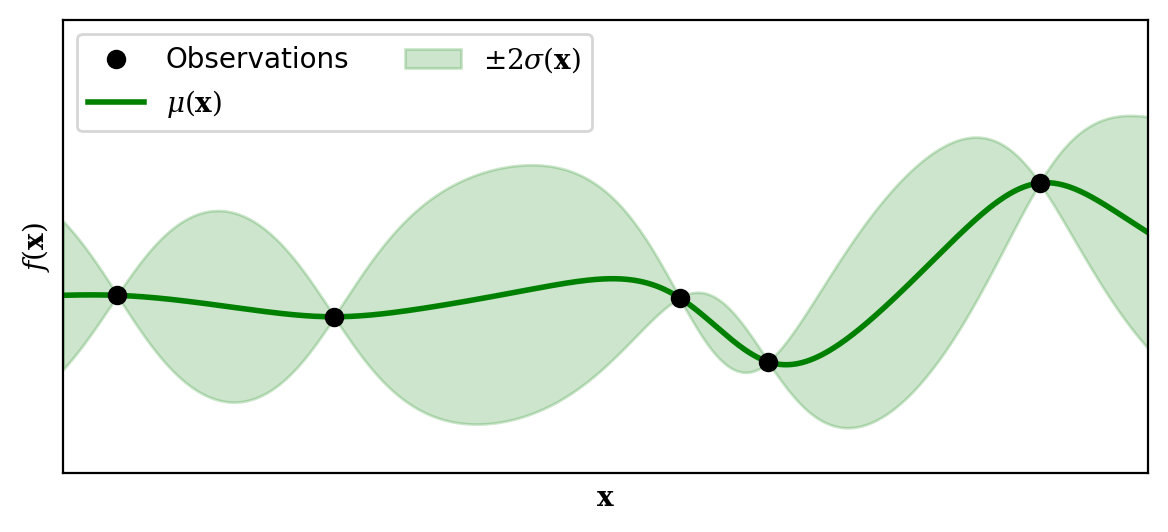

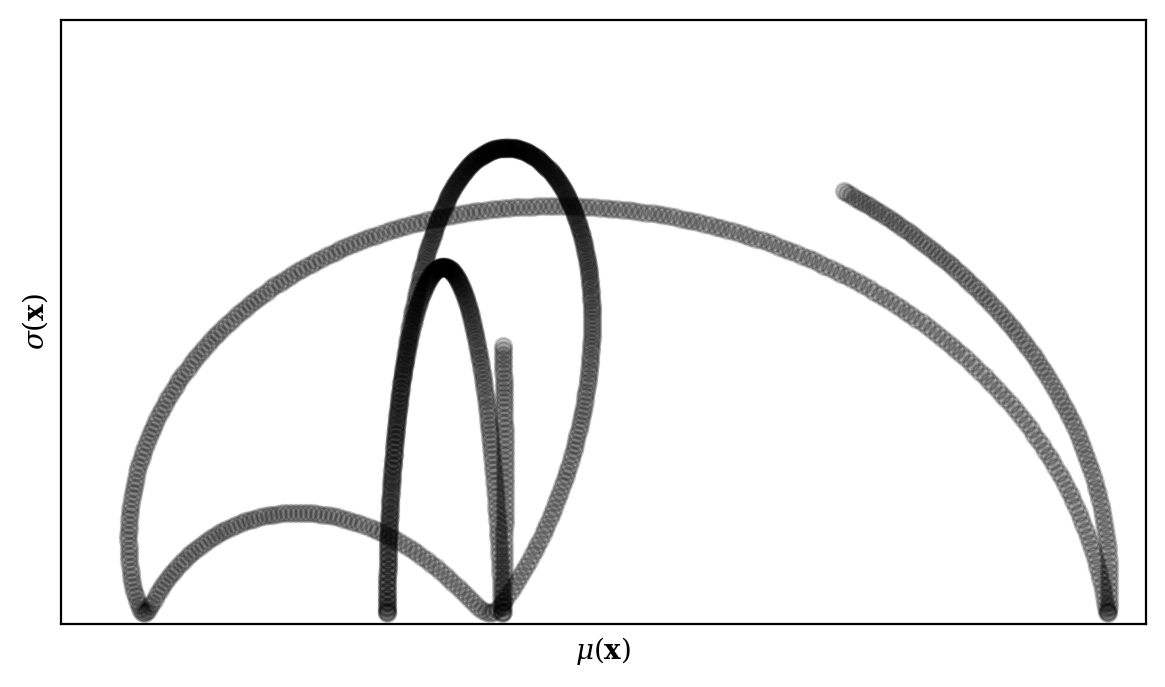

In [11]:
ax = get_1_axis(xlim, [-1.7, 2.8], figsize=(7, 3))
plot_1d_model(model, likelihood, xrange=[0, 1], ax=ax, dtype=dtype)
ax.legend(loc="upper left", ncol=2)
ax.set_xlabel('$\mathbf{x}$')
ax.set_ylabel('$f(\mathbf{x})$')
plt.savefig(f"egreedy_0_GP.pdf", bbox_inches="tight")
plt.show()

ax = get_1_axis([-0.75, 1.25], [0, 0.8], figsize=(7, 4))
ax.plot(mu, sigma, 'ko', alpha=0.2)
ax.set_xlabel('$\mu(\mathbf{x})$')
ax.set_ylabel('$\sigma(\mathbf{x})$')
plt.savefig(f"egreedy_0_PF.pdf", bbox_inches="tight")
plt.show()

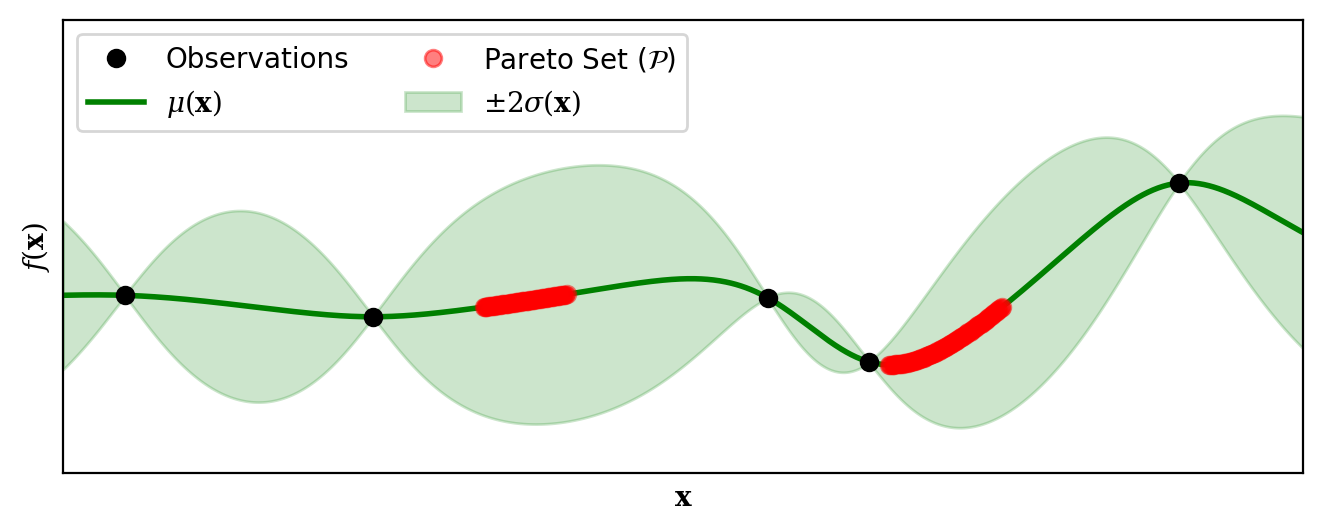

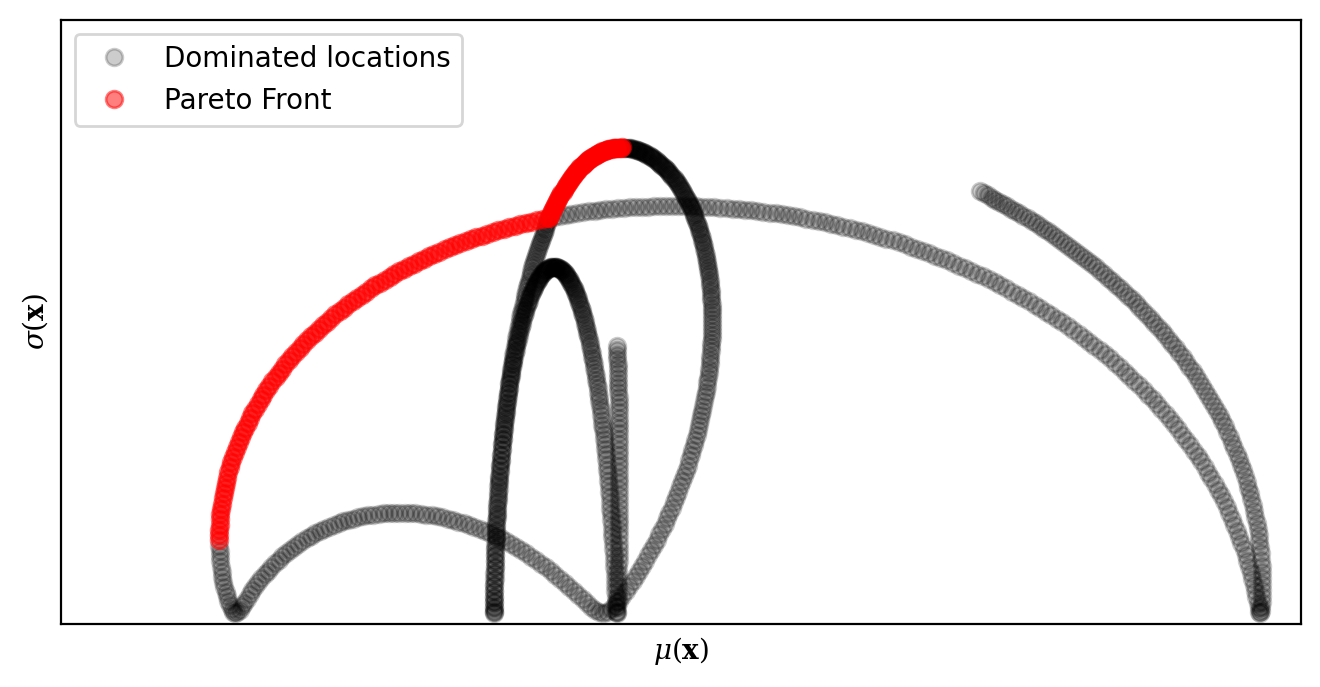

In [12]:
ax = get_1_axis(xlim, [-1.7, 2.8], figsize=(8, 3))
plot_1d_model(model, likelihood, ax=ax, dtype=dtype)

ax.plot(
    xtest.numpy().flat[front_mask],
    mu.flat[front_mask],
    "ro",
    label="Pareto Set ($\mathcal{P}$)",
    alpha=0.5,
)

ax.legend(loc="upper left", ncol=2)
ax.set_xlabel("$\mathbf{x}$")
ax.set_ylabel("$f(\mathbf{x})$")
plt.savefig(f"egreedy_1_GP.pdf", bbox_inches="tight")
plt.show()

ax = get_1_axis([-0.9, 1.25], [0, 0.8], figsize=(8, 4))
ax.plot(
    mu[~front_mask],
    sigma[~front_mask],
    "ko",
    alpha=0.2,
    label="Dominated locations",
)
ax.plot(
    mu[front_mask], sigma[front_mask], "ro", alpha=0.5, label="Pareto Front",
)
ax.legend(loc="upper left", ncol=1)
ax.set_xlabel("$\mu(\mathbf{x})$")
ax.set_ylabel("$\sigma(\mathbf{x})$")
plt.savefig(f"egreedy_1_PF.pdf", bbox_inches="tight")
plt.show()